In [ ]:
!pip install torchmetrics

In [2]:
# this line copies labels.csv and move it to colab temporary directory for efficiency
!cp "/content/drive/MyDrive/Doutorado/Deep Learning MIT/Chest_X_Ray Pneumonia Dataset/archive/chest_xray/labels.csv" /content/

In [ ]:
# this command copies all the images to colabs temporary directory for efficiency
%cd "/content"
%cp -av "/content/drive/MyDrive/Doutorado/Deep Learning MIT/Chest_X_Ray Pneumonia Dataset/archive/chest_xray/img_dir" .

In [4]:
import os
import time, copy
import pandas as pd
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy

# csv file containing filename and correct label
annotations_file = "/content/labels.csv"

# directory containing all images
img_dir = "/content/img_dir"

# hyperparameters
batch_size = 64
image_size = 256
nc = 3 # number of channels
nf = 64 # number of features to begin with
dropout = 0.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
root = "/content/drive/MyDrive/Doutorado/Deep Learning MIT/Chest_X_Ray Pneumonia Dataset"

In [6]:
# setup transforms and Dataset
transform = transforms.Compose([
                               transforms.Resize(image_size, antialias=True),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

class ChestXRayDataset(Dataset):
    def __init__(self, annotations_file, img_dir=img_dir, transform=transform, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, usecols=['filename','label'])      
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform: 
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image.to(device), label

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# setup model
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class XRayClassifier(nn.Module):
    def __init__(self, nc=nc, nf=nf, dropout=dropout):
        super(XRayClassifier, self).__init__()

        self.resnet_blocks = nn.Sequential(
            ResNetBlock(nc,   nf,    stride=2), # (B, C, H, W) -> (B, NF, H/2, W/2), i.e., (64,64,128,128)
            ResNetBlock(nf,   nf*2,  stride=2), # (64,128,64,64)
            ResNetBlock(nf*2, nf*4,  stride=2), # (64,256,32,32)
            ResNetBlock(nf*4, nf*8,  stride=2), # (64,512,16,16)
            ResNetBlock(nf*8, nf*16, stride=2), # (64,1024,8,8)
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(nf*16, 1, 8, 1, 0, bias=False),
            nn.Dropout(p=dropout),
            nn.Sigmoid(),
        )

    def forward(self, input):
        output = self.resnet_blocks(input.to(device))
        output = self.classifier(output)
        return output

In [8]:
# inspect labels
labels_df = pd.read_csv(annotations_file, usecols=['filename','label'])

# split the data into training and testing sets
train_val_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=42)

# split the training and validation data
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# write files
train_df.to_csv('train_set.csv')
val_df.to_csv('val_set.csv')
test_df.to_csv('test_set.csv')

In [9]:
# Prepare datasets
train_set = ChestXRayDataset('train_set.csv')
val_set = ChestXRayDataset('val_set.csv')
test_set = ChestXRayDataset('test_set.csv')
full_set = ChestXRayDataset(annotations_file)

# Prepare dataloaders
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

dataloaders = {'train': train_dataloader,
               'val': val_dataloader,
               'test': test_dataloader}

dataset_sizes = {'train': len(train_set),
                 'val': len(val_set),
                 'test': len(test_set)}

In [10]:
dataset_sizes

{'train': 3750, 'val': 938, 'test': 1172}

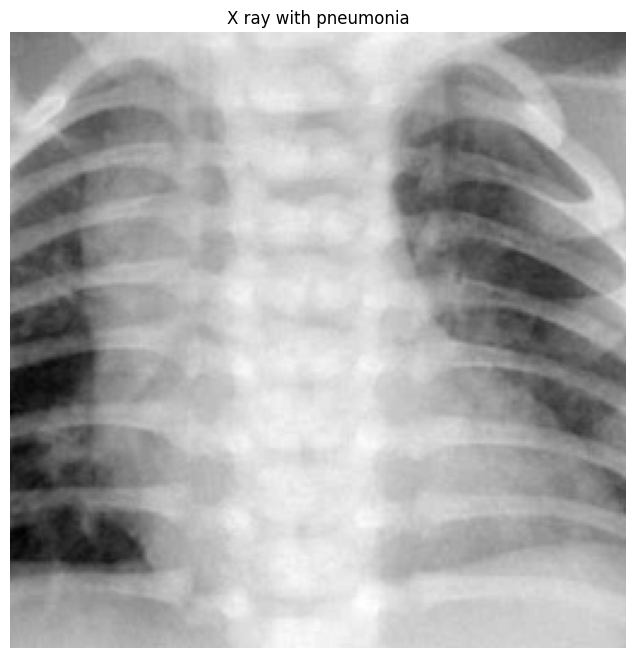

In [11]:
import random
import matplotlib.pyplot as plt
import torchvision.utils as vutils

idx = random.randint(0, dataset_sizes['train'])
img = train_set[idx][0]
label = train_set[idx][1]

# data visualization
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title(f"{'X ray with pneumonia' if label == 1 else 'X ray without pneumonia'}")
plt.imshow(np.transpose(vutils.make_grid(img, padding=2, normalize=True).cpu(),(1,2,0)))

In [12]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=5, threshold=0.5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0
    best_f1 = 0

    # initialize metric
    f1 = BinaryF1Score(threshold=threshold).to(device)
    acc = BinaryAccuracy(threshold=threshold).to(device)

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']
    
    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []
        training_curves[phase+'_f1'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            since_phase = time.time()
                        
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.view(-1), labels.to(torch.float))

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                f1_score = f1(outputs.view(-1), labels)
                acc_score = acc(outputs.view(-1), labels)
                            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = acc.compute()
            epoch_f1 = f1.compute()
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)       
            training_curves[phase+'_f1'].append(epoch_f1)
            phase_time_elapsed = time.time() - since_phase

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} Time elapsed: {phase_time_elapsed // 60:.0f}m {phase_time_elapsed % 60:.0f}s')

            # deep copy the model if it's the best F1
            if phase == 'val' and epoch_f1 > best_f1:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
              best_f1 = epoch_f1

            # reset metrics
            f1.reset()
            acc.reset()

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch} with F1-score: {best_f1}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, training_curves

In [ ]:
learning_rate = 0.0001
num_epochs = 20
dropout = 0.2
weight_decay = 0

model = XRayClassifier().to(device)
criterion = nn.BCELoss() # For binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
model, training_curves = train_classification_model(model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/20
----------
train Loss: 0.5604 Acc: 0.7691 F1: 0.8239 Time elapsed: 2m 0s
val   Loss: 0.1732 Acc: 0.9339 F1: 0.9558 Time elapsed: 0m 22s
test  Loss: 0.1894 Acc: 0.9317 F1: 0.9544 Time elapsed: 0m 28s

Epoch 2/20
----------
train Loss: 0.2084 Acc: 0.8355 F1: 0.8759 Time elapsed: 1m 50s
val   Loss: 0.1758 Acc: 0.9382 F1: 0.9572 Time elapsed: 0m 23s
test  Loss: 0.1652 Acc: 0.9454 F1: 0.9621 Time elapsed: 0m 29s

Epoch 3/20
----------
train Loss: 0.1605 Acc: 0.8451 F1: 0.8821 Time elapsed: 1m 49s
val   Loss: 0.1484 Acc: 0.9478 F1: 0.9642 Time elapsed: 0m 23s
test  Loss: 0.1532 Acc: 0.9471 F1: 0.9634 Time elapsed: 0m 27s

Epoch 4/20
----------
train Loss: 0.1415 Acc: 0.8539 F1: 0.8890 Time elapsed: 1m 50s
val   Loss: 0.1556 Acc: 0.9446 F1: 0.9619 Time elapsed: 0m 21s
test  Loss: 0.1626 Acc: 0.9514 F1: 0.9663 Time elapsed: 0m 27s

Epoch 5/20
----------
train Loss: 0.1412 Acc: 0.8504 F1: 0.8860 Time elapsed: 1m 50s
val   Loss: 0.1541 Acc: 0.9531 F1: 0.9681 Time elapsed: 0m 21s
test

In [ ]:
models_path = os.path.join(root, 'models', f'chestxray_classifier.model')
torch.save(model.state_dict(), models_path)

In [ ]:
import sklearn.metrics as metrics

# Utility functions for plotting your results!
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc', 'f1']):
    epochs = list(range(1, len(training_curves['train_loss'])+1))
    fig, axs = plt.subplots(len(metrics), 1, figsize=(5, 10), tight_layout=True)
    for idx, metric in enumerate(metrics):
        ax = axs[idx]     
        ax.set_title(f'Training curves - {metric}')
        ax.set_ylabel(metric)
        ax.xaxis.set_ticks(np.arange(1, len(epochs)+1, 1))
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc' or metric == 'f1':
                    ax.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    ax.plot(epochs, training_curves[key])
        ax.set_xlabel('epoch')
        ax.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = torch.where(outputs < 0.5, 0, 1).view(-1)
        scores = outputs.view(-1)
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0).view(-1)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


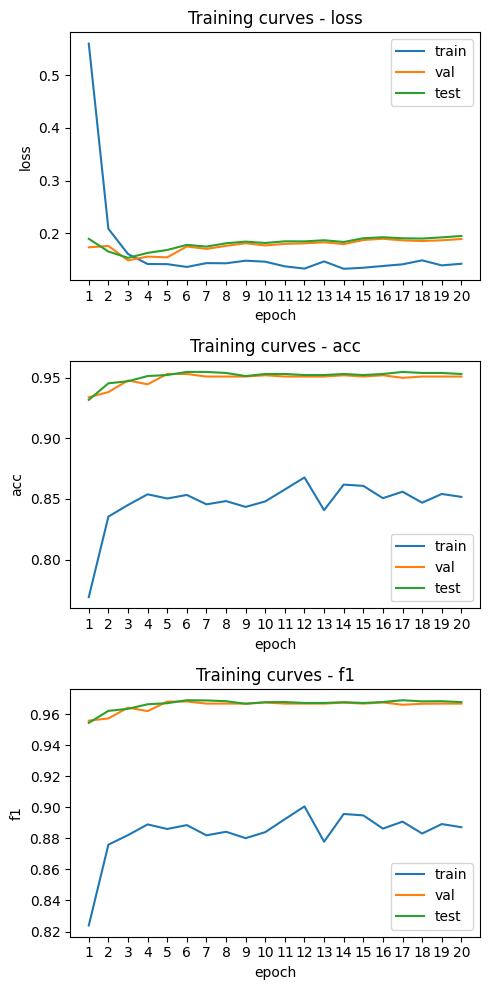

In [ ]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

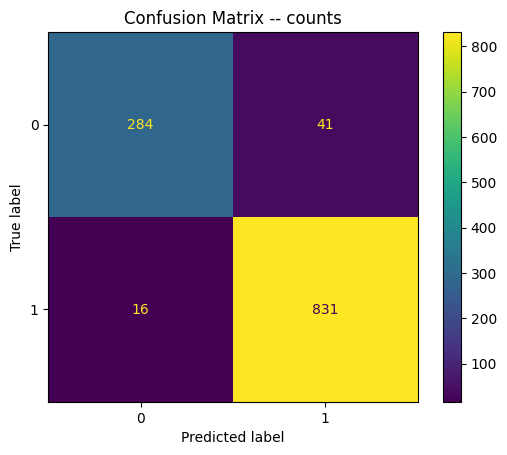

In [ ]:
res = plot_cm(model, device, dataloaders, phase='test')

# Implementing Grad-CAM from scratch


In [86]:
# Load pre-trained model
model_path = os.path.join(root, 'models','chestxray_classifier.model')
model = XRayClassifier().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

XRayClassifier(
  (resnet_blocks): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, mom

In [47]:
# Define forward and backward hook functions
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients
  print('Backward hook running...')
  gradients = grad_output
  print(f'Gradients size: {gradients[0].size()}')

def forward_hook(module, args, output):
  global activations
  print('Forward hook running...')
  activations = output
  print(f'Activations size: {activations.size()}')

In [48]:
# Register hooks in pre-trained models
backward_hook = model.resnet_blocks[-1].register_full_backward_hook(backward_hook, prepend=False)
forward_hook = model.resnet_blocks[-1].register_forward_hook(forward_hook, prepend=False)

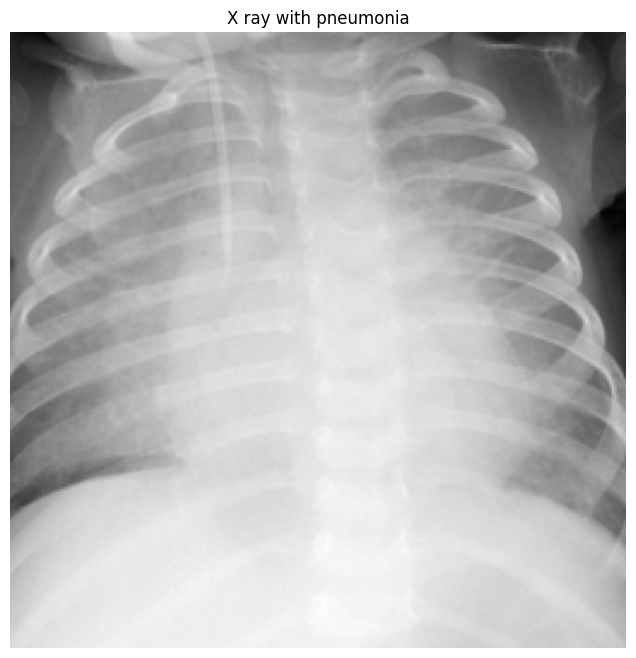

In [43]:
# Select a random image for visualization 
idx = random.randint(0, dataset_sizes['train'])
img = train_set[idx][0]
label = train_set[idx][1]

# data visualization
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title(f"{'X ray with pneumonia' if label == 1 else 'X ray without pneumonia'}")
plt.imshow(np.transpose(vutils.make_grid(img, padding=2, normalize=True).cpu(),(1,2,0)))

In [50]:
# Do the forward and backward pass using image as input
model(img.unsqueeze(0)).backward() # unsqueeze because the model expects 4d tensors

Forward hook running...
Activations size: torch.Size([1, 1024, 8, 8])
Backward hook running...
Gradients size: torch.Size([1, 1024, 8, 8])


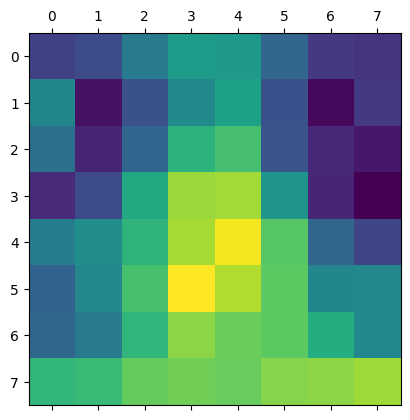

In [64]:
def gradcam(activations, gradients):
  # pool the gradients across the channels
  pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
  pooled_gradients.size()

  # weight the channels by corresponding gradients
  for i in range(activations.size()[1]):
      activations[:, i, :, :] *= pooled_gradients[i]

  # average the channels of the activations
  heatmap = torch.mean(activations, dim=1).squeeze()

  # relu on top of the heatmap
  heatmap = F.relu(heatmap)

  # normalize the heatmap
  heatmap /= torch.max(heatmap)
  return heatmap

heatmap = gradcam(activations, gradients)

# draw the heatmap
# Needs to unable autograd and move tensor to cpu so it can be converted to numpy array
plt.matshow(heatmap.cpu().detach()) 

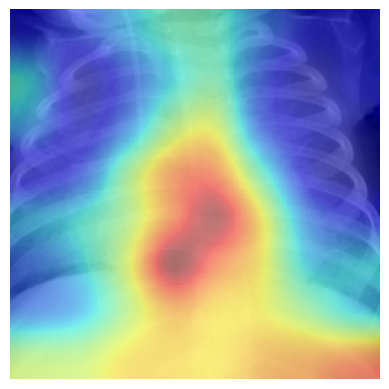

In [65]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL
from typing import Tuple

# Create a figure and plot the first image
fig, ax = plt.subplots()
ax.axis('off') # removes the axis markers

# First plot the original image
ax.imshow(np.transpose(vutils.make_grid(img, padding=2, normalize=True).cpu(),(1,2,0)))

def upscale_heatmap(heatmap: torch.Tensor, 
                    size: Tuple = (256,256), 
                    resample = PIL.Image.BICUBIC,
                    colormap: str = 'jet'):
  # Resize the heatmap to the same size as the input image and defines
  # a resample algorithm for increasing image resolution
  # we need heatmap.detach() because it can't be converted to numpy array while
  # requiring gradients
  overlay = to_pil_image(heatmap.detach(), mode='F').resize(size, resample=resample)

  # Apply any colormap you want
  cmap = colormaps[colormap]
  overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
  return overlay

# Plot the heatmap on the same axes, 
# but with alpha < 1 (this defines the transparency of the heatmap)
# define extent to which we'll upscale the heatmap (same as img)
overlay = upscale_heatmap(heatmap)
ax.imshow(overlay, alpha=0.5, interpolation='nearest')

# Show the plot
plt.show()

Forward hook running...
Activations size: torch.Size([1, 1024, 8, 8])
Backward hook running...
Gradients size: torch.Size([1, 1024, 8, 8])


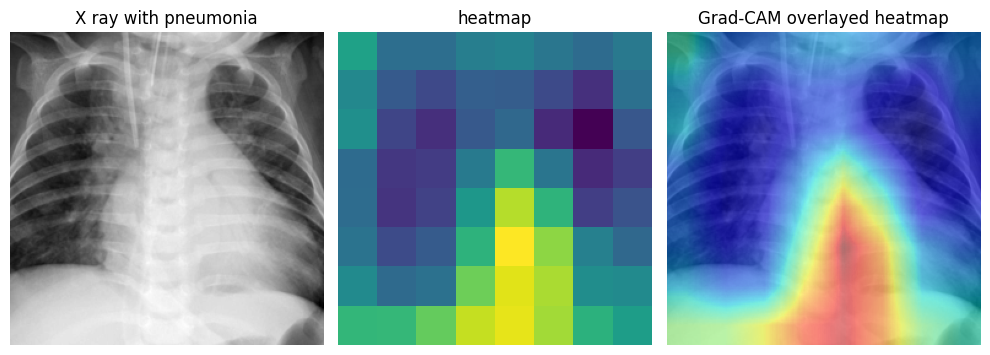

Prediction: x ray has pneumonia


In [81]:
# idx = random.randint(0, dataset_sizes['test'])
# img = train_set[idx][0]
# label = train_set[idx][1]

# data visualization
fig, axs = plt.subplots(1, 3, figsize=(10, 15), tight_layout=True)
axs[0].set_title(f"{'X ray with pneumonia' if label == 1 else 'X ray without pneumonia'}")
axs[0].axis('off')
axs[0].imshow(np.transpose(vutils.make_grid(img, padding=2, normalize=True).cpu(),(1,2,0)))

out = model(img.unsqueeze(0))
out.backward()

# The raw CAM
heatmap = gradcam(activations, gradients)
axs[1].set_title("heatmap")
axs[1].axis('off')
axs[1].imshow(heatmap.cpu().detach())

# Overlayed on the image
axs[2].set_title("Grad-CAM overlayed heatmap")
axs[2].axis('off')
axs[2].imshow(np.transpose(vutils.make_grid(img, padding=2, normalize=True).cpu(),(1,2,0)))
overlay = upscale_heatmap(heatmap)
axs[2].imshow(overlay, alpha=0.5, interpolation='nearest')


plt.show()

prediction = torch.where(out.squeeze() > 0.5, 1, 0)
if prediction==1: print("Prediction: x ray has pneumonia") 
else: print("Prediction: x ray doesn't have pneumonia") 

# Implementing Grad-CAM using torch-cam

In [ ]:
!pip install torchcam

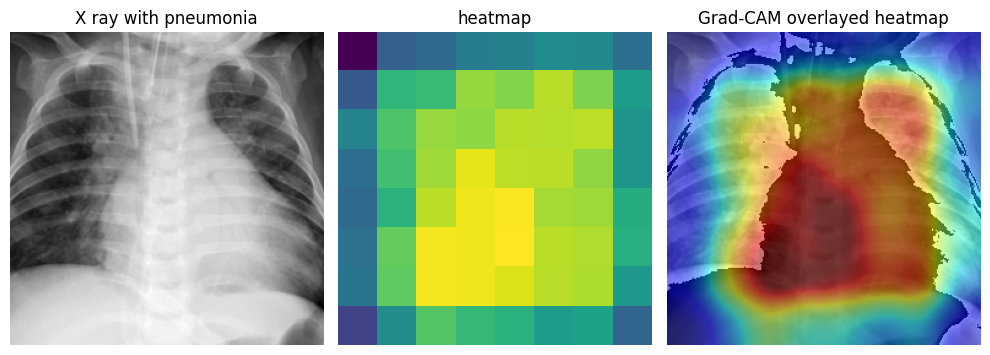

Prediction: x ray has pneumonia


In [87]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask

cam_extractor = SmoothGradCAMpp(model, input_shape=(3, 256, 256))

# Preprocess your data and feed it to the model
out = model(img.unsqueeze(0)) # unsqueeze is because the model expects 4d tensor

# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

# data visualization
fig, axs = plt.subplots(1, 3, figsize=(10, 15), tight_layout=True)
axs[0].set_title(f"{'X ray with pneumonia' if label == 1 else 'X ray without pneumonia'}")
axs[0].axis('off')
axs[0].imshow(np.transpose(vutils.make_grid(img, padding=2, normalize=True).cpu(),(1,2,0)))

# The raw CAM
axs[1].set_title("heatmap")
axs[1].axis('off')
axs[1].imshow(cams[0].squeeze(0).cpu().numpy())

result = overlay_mask(to_pil_image(img, mode='RGB'), to_pil_image(cams[0].squeeze(0), mode='F'), alpha=0.5)
axs[2].set_title("Grad-CAM overlayed heatmap")
axs[2].axis('off')
axs[2].imshow(result)

plt.show()

# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()

prediction = torch.where(out.squeeze() > 0.5, 1, 0)
if prediction==1: print("Prediction: x ray has pneumonia") 
else: print("Prediction: x ray doesn't have pneumonia") 